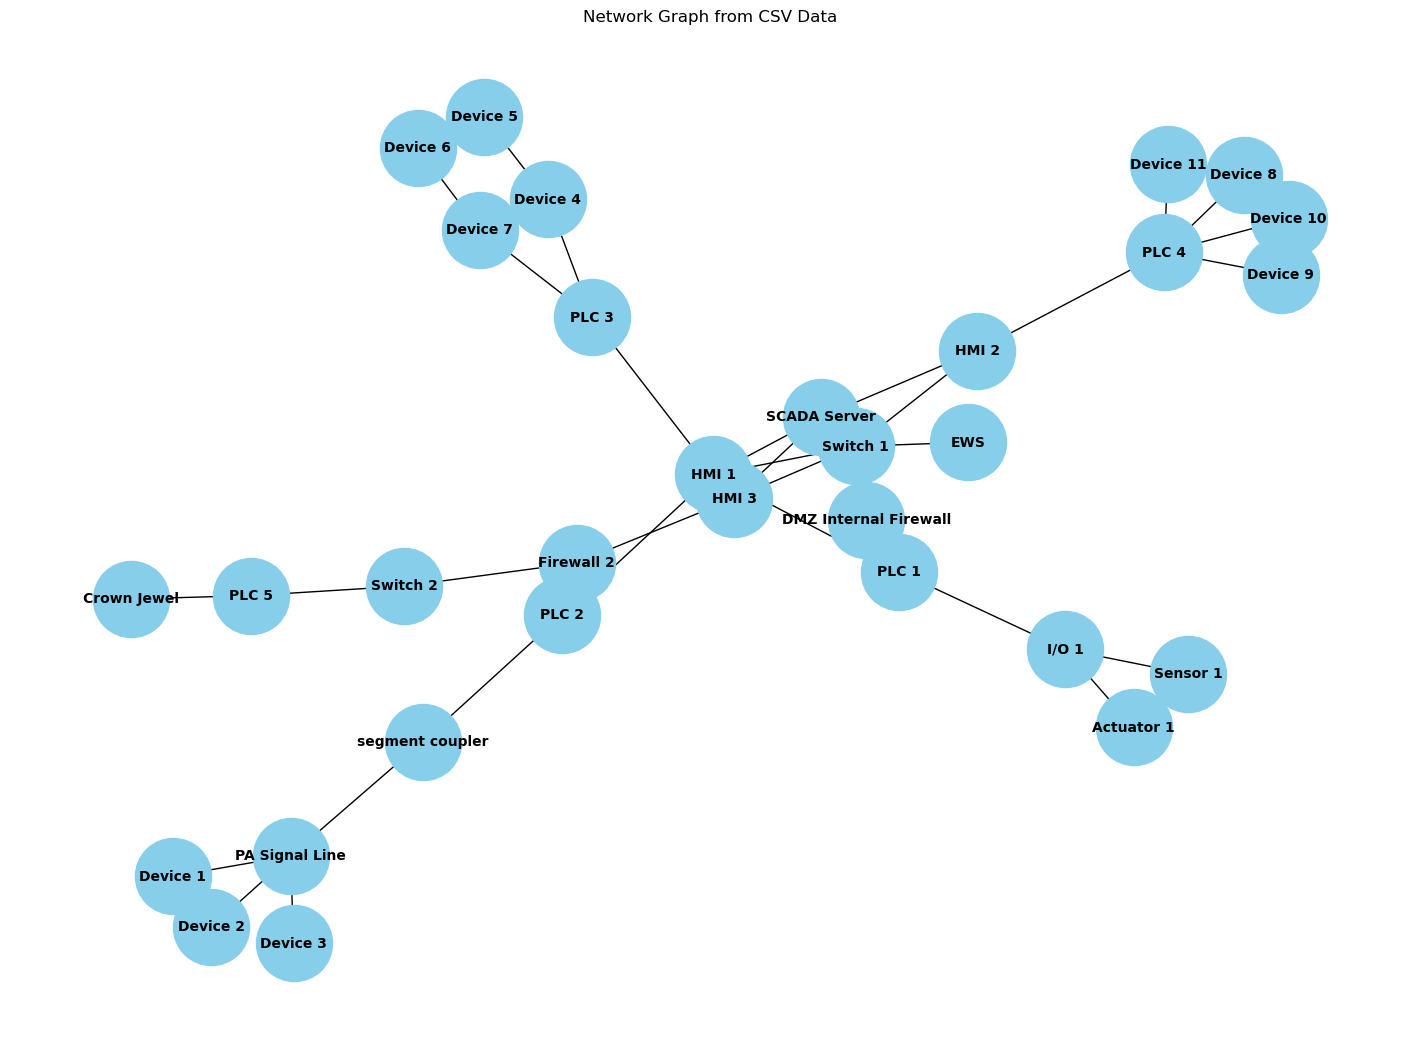

Fiedler Value of the Laplacian Matrix: 0.0680459103761321 

Fiedler Vector of the Laplacian Matrix:
         2         1         3         4         5         6         7   \
0 -0.064384 -0.069085 -0.062477 -0.069085  0.005828 -0.092653 -0.094449   

         8         9         10  ...        22        23        24        25  \
0  0.008836  0.011243  0.012064  ...  0.011243 -0.144794 -0.155366 -0.155366   

         26        27       28       29       30        31  
0 -0.155366 -0.155366 -0.15006 -0.19546 -0.22756 -0.244175  

[1 rows x 31 columns] 

Centrality Measures:
    Degree Centrality  Betweenness Centrality  Closeness Centrality  \
1            0.033333                0.000000              0.258621   
2            0.200000                0.367816              0.344828   
3            0.133333                0.236782              0.337079   
4            0.033333                0.000000              0.258621   
5            0.166667                0.687356              0.3529

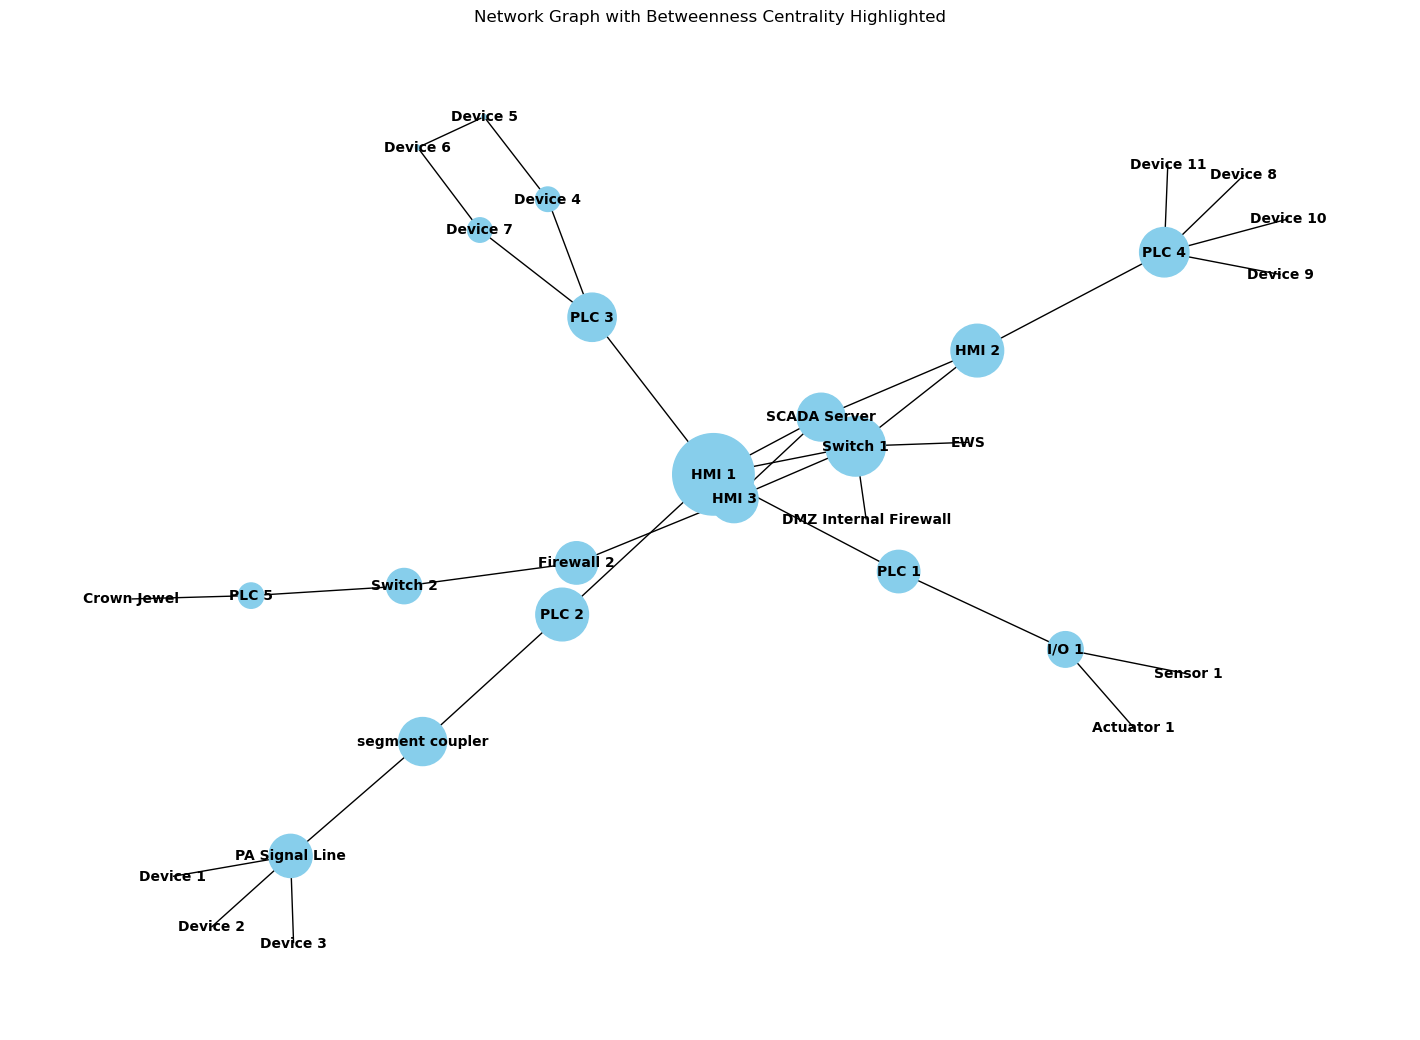

Detected Anomalies in Centrality Measures:
   Degree Centrality  Betweenness Centrality  Closeness Centrality  \
2           0.200000                0.367816              0.344828   
3           0.133333                0.236782              0.337079   
5           0.166667                0.687356              0.352941   

   Eigenvector Centrality  anomaly  
2                0.524418       -1  
3                0.455747       -1  
5                0.402488       -1  
Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


C:\Users\Service Casket\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.ensemble import IsolationForest
import seaborn as sns
from pyvis.network import Network

# Load the nodes and edges data
nodes_df = pd.read_csv('ICS_OT NodesInfected.csv')
edges_df = pd.read_csv('ICS_OT EdgesInfected.csv')

# Create an undirected graph
G = nx.Graph()

# Add nodes with labels and types of devices
for index, row in nodes_df.iterrows():
    G.add_node(row['Id'], label=row['Label'], shape=row.get('Shape', 'ellipse'))

# Add edges to represent connections
for index, row in edges_df.iterrows():
    G.add_edge(row['Source'], row['Target'])

# Define positions for nodes (this part should be adjusted based on actual layout if available)
pos = nx.spring_layout(G)

# Draw the graph
def draw_graph(G, pos, title, node_size=None):
    plt.figure(figsize=(14, 10))
    nx.draw(G, pos, with_labels=False, node_size=node_size if node_size else 3000, 
            node_color='skyblue', font_size=10, font_weight='bold')
    labels = nx.get_node_attributes(G, 'label')
    nx.draw_networkx_labels(G, pos, labels, font_size=10, font_weight='bold')
    plt.title(title)
    plt.show()

draw_graph(G, pos, "Network Graph from CSV Data")

# Initialize the adjacency matrix
node_labels = nodes_df['Id'].tolist()
node_indices = {label: index for index, label in enumerate(node_labels)}
num_nodes = len(node_labels)
adjacency_matrix = np.zeros((num_nodes, num_nodes))

# Fill the adjacency matrix
for _, row in edges_df.iterrows():
    source_index = node_indices[row['Source']]
    target_index = node_indices[row['Target']]
    adjacency_matrix[source_index, target_index] = 1
    adjacency_matrix[target_index, source_index] = 1  # For undirected graph

# Function to print matrices and vectors
def print_matrix(name, matrix, labels):
    print(f"{name}:")
    print(pd.DataFrame(matrix, index=labels, columns=labels), "\n")

def print_eigen(name, eigenvalues, eigenvectors, labels):
    eigenvalues_df = pd.DataFrame(eigenvalues).T
    #print(f"{name} Eigenvalues:")
    #print(eigenvalues_df.to_string(index=False, header=False), "\n")
    #print(f"{name} Eigenvectors:")
    #print(pd.DataFrame(eigenvectors, index=labels), "\n")

#print_matrix("Adjacency Matrix", adjacency_matrix, node_labels)

# Calculate and print eigenvalues and eigenvectors of the adjacency matrix
adj_eigenvalues, adj_eigenvectors = np.linalg.eig(adjacency_matrix)
print_eigen("Adjacency Matrix", adj_eigenvalues, adj_eigenvectors, node_labels)

# Calculate and print the Laplacian matrix and its eigenvalues and eigenvectors
laplacian_matrix = np.diag(adjacency_matrix.sum(axis=1)) - adjacency_matrix
#print_matrix("Laplacian Matrix", laplacian_matrix, node_labels)

lap_eigenvalues, lap_eigenvectors = np.linalg.eig(laplacian_matrix)
#print_eigen("Laplacian Matrix", lap_eigenvalues, lap_eigenvectors, node_labels)

# Calculate the spectral radius of the Laplacian matrix
spectral_radius = max(abs(lap_eigenvalues))
#print("Spectral Radius of the Laplacian Matrix:", spectral_radius, "\n")

# Calculate and print the Fiedler value and vector of the Laplacian matrix
fiedler_index = np.argsort(lap_eigenvalues)[1]
fiedler_value = lap_eigenvalues[fiedler_index]
fiedler_vector = lap_eigenvectors[:, fiedler_index]

print("Fiedler Value of the Laplacian Matrix:", fiedler_value, "\n")
print("Fiedler Vector of the Laplacian Matrix:")
print(pd.DataFrame(fiedler_vector, index=node_labels).T, "\n")

# Calculate centrality measures
centrality_measures = {
    'Degree Centrality': nx.degree_centrality(G),
    'Betweenness Centrality': nx.betweenness_centrality(G),
    'Closeness Centrality': nx.closeness_centrality(G),
    'Eigenvector Centrality': nx.eigenvector_centrality(G)
}

centrality_df = pd.DataFrame(centrality_measures).sort_index()

# Display centrality measures
print("Centrality Measures:")
print(centrality_df)

# Visualize the graph with betweenness centrality highlighted
node_size = [v * 5000 for v in centrality_measures['Betweenness Centrality'].values()]
draw_graph(G, pos, "Network Graph with Betweenness Centrality Highlighted", node_size=node_size)

# Anomaly detection using Isolation Forest on centrality measures
def detect_anomalies(df):
    iso_forest = IsolationForest(contamination=0.1)
    df['anomaly'] = iso_forest.fit_predict(df)
    return df

anomalies = detect_anomalies(centrality_df)

# Print anomalies
print("Detected Anomalies in Centrality Measures:")
print(anomalies[anomalies['anomaly'] == -1])

# Visualize the network using PyVis
def visualize_network(G, title):
    net = Network(notebook=True)
    net.from_nx(G)
    net.show(f'{title}.html')

visualize_network(G, "Network Graph")